In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
!pip install gymnasium[classic-control]
import gymnasium as gym

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
cart_pos_bin = np.linspace(-4.8,4.8,11)
cart_v_bin = np.linspace(-2^8,2^8,11)
pole_angle_bin = np.linspace(-0.418,0.418,11)
pole_angularV_bin = np.linspace(-2^8,2^8,11)
BINS = np.stack((cart_pos_bin, cart_v_bin, pole_angle_bin, pole_angularV_bin))

# Collect Data with Q-Learning

In [ ]:
def one_hot(state):

  '''
  state: a (4,) numpy array from observation space
  return: a (10000,) numpy array which is the one-hot encoding of the state
          and index of the 1
  '''

  encoding = np.zeros(10000)
  bin_indicies = np.zeros(4)

  for i in range(4):
    for j in range(10):
      if state[i] >= BINS[i,j] and state[i] < BINS[i,j+1]:
        bin_indicies[i] = j
        break

  index = 0
  for i in range(4):
    index += bin_indicies[i]*10**(3-i)

  encoding[int(index)] = 1

  return encoding, int(index)

In [ ]:
def epsilon_greedy(q, epsilon):

  if (random.random() < epsilon):
    action = random.randint(0,1) # pick a random action
  else:
    action = np.argmax(q) # greedy

  return action

In [ ]:
alpha = 1/4
epsilon = 1
gamma = 1
decay = 0.99

## train

In [ ]:
returns = np.zeros(1000)
theta = np.random.uniform(-0.001, 0.001, (2,10000))

for e in range(1000):

    # start at random initial state
    curr_state, info = env.reset()
        
    terminated = False
    truncated = False
        
    while not terminated and not truncated:

      feature, curr_state_idx = one_hot(curr_state)

      # choose A from S using e-greedy
      curr_action = epsilon_greedy(theta[:,curr_state_idx], epsilon)

      # take action A, observe reward and next state
      next_state, reward, terminated, truncated, info = env.step(curr_action)

      # update Q(S,A)
      if terminated:
        target = reward
      else:
        _, next_state_idx = one_hot(next_state)
        target = reward+gamma*np.max(theta[:,next_state_idx])
          
      theta[curr_action] += alpha*(target-theta[curr_action,curr_state_idx])*feature
      curr_state = next_state
      returns[e] += 1

    epsilon *= decay
    
    if e%200==199:
      print(returns[e])

36.0
290.0
500.0
176.0
500.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/COMP 579/weights.txt', 'w') as f:
  np.savetxt(f, theta)

In [ ]:
with open('/content/drive/My Drive/COMP 579/weights.txt', 'r') as f:
  theta = np.loadtxt(f)

## gather 500 behavior episodes

In [ ]:
expert_data = []

for e in range(500):

  curr_state, info = env.reset()
        
  terminated = False
  truncated = False
  
  temp = []
  while not terminated and not truncated:
    _, curr_state_idx = one_hot(curr_state)
    action = np.argmax(theta[:,curr_state_idx])
    next_state, reward, terminated, truncated, info = env.step(action)
    temp.append([curr_state, action, next_state, reward])
    curr_state = next_state
    
  expert_data.append(temp)

In [ ]:
random_data = []

for e in range(500):

  curr_state, info = env.reset()
        
  terminated = False
  truncated = False
  
  temp = []
  while not terminated and not truncated:
    action = random.randint(0,1)
    next_state, reward, terminated, truncated, info = env.step(action)
    temp.append([curr_state, action, next_state, reward])
    curr_state = next_state
  
  random_data.append(temp)

# Imitation Learning

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
    
    def gradient(self, x, y):
        N,D = x.shape
        yh = 1/(1+np.exp(-np.dot(x, self.w)))
        grad = np.dot(x.T, (yh-y))/N
        return grad

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
            #print(np.linalg.norm(g))
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
          x = x[:, None]
          if self.add_bias:
            x = np.vstack([x,[1]]).flatten()
            return 1/(1+np.exp(-np.dot(x, self.w)))
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = 1/(1+np.exp(-np.dot(x, self.w)))
        return yh

## data processing

In [ ]:
def process_data(dataset, x, y, idx1, idx2, mixed=False):

  for i in range(500):

    if mixed:
      random.seed(i)
      dice = random.random()
      if dice < 0.5:
        dataset = expert_data
      else:
        dataset = random_data
    steps = len(dataset[i])

    for j in range(steps):

      state = dataset[i][j][idx1]
      action = dataset[i][j][idx2]

      if i==0 and j==0:
        temp_x = state
        temp_y = [action]
      else:
        temp_x = np.vstack((temp_x, state))
        temp_y.append(action)
        if (i==99 or i==249 or i==499) and j==steps-1:
          x.append(temp_x)
          y.append(np.array(temp_y))
    
  return x,y

In [ ]:
x, y = process_data(expert_data, [], [], 0, 1)
x, y = process_data([], x, y, 0, 1, mixed=True)
x, y = process_data(random_data, x, y, 0, 1)

## test estimator

In [ ]:
returns = np.zeros((9,2,100))
learning_rates = [0.1, 0.01]

for i in range(9):
  for j, lr in enumerate(learning_rates):
    
    model = LogisticRegression(learning_rate=lr)
    model.fit(x[i],y[i])

    for e in range(100):
      
      curr_state, info = env.reset()
            
      terminated = False
      truncated = False
      
      while not terminated and not truncated:
        if model.predict(curr_state) > 0.5:
          action = 1
        else:
          action = 0
        next_state, reward, terminated, truncated, info = env.step(action)
        curr_state = next_state
        returns[i,j,e] += 1


In [ ]:
imitation_avg_returns = np.mean(returns, axis=2)
imitation_stderr = np.std(returns, axis=2)/10

In [ ]:
imitation_avg_returns

array([[500.  , 246.17],
       [500.  , 230.47],
       [500.  , 213.09],
       [500.  , 226.87],
       [500.  , 205.84],
       [500.  , 183.48],
       [  9.35,   9.36],
       [  9.35,   9.31],
       [  9.37,   9.25]])

In [ ]:
with open('/content/drive/My Drive/COMP 579/imitation_avg.txt', 'w') as f:
  np.savetxt(f, imitation_avg_returns)

with open('/content/drive/My Drive/COMP 579/imitation_stderr.txt', 'w') as f:
  np.savetxt(f, imitation_stderr)

# Fitted Q-Learning

In [ ]:
# lists of 9 arrays of length N (# of steps)
curr_states = x
actions = y
s, r = process_data(expert_data, [], [], 2, 3)
s, r = process_data([], s, r, 2, 3, mixed=True)
s, r = process_data(random_data, s, r, 2, 3)
next_states = s
rewards = r

In [ ]:
def Q(state_array, phi):
  '''
  inputs: state_array (N,4), phi (10000,2)
  output: q (N,2)
  '''
  q = np.zeros((len(state_array),2))
  for i in range(len(state_array)):
    _, idx = one_hot(state_array[i])
    q[i] = phi[idx]
  return q

In [ ]:
returns = np.zeros((9,2,100))
learning_rates = [0.1, 0.01]
gamma = 0.99
max_iters = 100
K = 10

for i in range(9):

  for j, lr in enumerate(learning_rates):
    
    phi = np.random.uniform(-0.001, 0.001, (10000,2))

    # dataset for a particular condition
    curr_state = curr_states[i]   # N*4
    action = actions[i]           # N
    next_state = next_states[i]   # N*4
    reward = rewards[i]           # N

    # train
    for k in range(K):
      y = reward + gamma*np.max(Q(next_state, phi), axis=1)  # N
      for s in range(len(y)):
        _, idx = one_hot(curr_state[s])
        phi[idx,action[s]] += lr * (y[s] - phi[idx,action[s]])
      ''' alternative implementation of gradient descent that 
      makes more sense but have every large time/space complexity:
      for t in range(max_iters):
        phi[:,0] += lr * (y - feature@phi[:,0]) @ feature
        phi[:,1] += lr * (y - feature@phi[:,1]) @ feature
      where feature is a N*10000 sparse matrix
      '''

    # test
    for e in range(100):
      cs, info = env.reset()
      terminated = False
      truncated = False
      while not terminated and not truncated:
        _, idx = one_hot(cs)
        a = np.argmax(phi[idx])
        ns, r, terminated, truncated, info = env.step(a)
        cs = ns
        returns[i,j,e] += 1

In [ ]:
fittedQ_avg_return = np.mean(returns, axis=2)
fittedQ_stderr = np.std(returns, axis=2)/10

In [ ]:
with open('/content/drive/My Drive/COMP 579/fittedQ_avg.txt', 'w') as f:
  np.savetxt(f, fittedQ_avg_return)

with open('/content/drive/My Drive/COMP 579/fittedQ_stderr.txt', 'w') as f:
  np.savetxt(f, fittedQ_stderr)

# Plot

In [ ]:
with open('/content/drive/My Drive/COMP 579/imitation_avg.txt', 'r') as f:
  imitation_avg_returns = np.loadtxt(f)

with open('/content/drive/My Drive/COMP 579/imitation_stderr.txt', 'r') as f:
  imitation_stderr = np.loadtxt(f)

In [ ]:
with open('/content/drive/My Drive/COMP 579/fittedQ_avg.txt', 'r') as f:
  fittedQ_avg_returns = np.loadtxt(f)

with open('/content/drive/My Drive/COMP 579/fittedQ_stderr.txt', 'r') as f:
  fittedQ_stderr = np.loadtxt(f)

In [ ]:
# average return of the expert and random policy
expert_avg = np.sum(rewards[2])/500
random_avg = np.sum(rewards[8])/500

In [ ]:
def reshape(array):
  ''' i dont know what i was thinking
  input (9,2)                     output (2,3,3)
  [[exp100lr1,  exp100lr2],       [[[exp100lr1, mix100lr1, rand100lr1],
   [exp250lr1,  exp250lr2],         [exp250lr1, mix250lr1, rand250lr1],
   [exp500lr1,  exp500lr2],         [exp500lr1, mix500lr1, rand500lr1]],
   [mix100lr1,  mix100lr2],        [[exp100lr2, mix100lr2, rand100lr2],
   [mix250lr1,  mix250lr2],         [exp250lr2, mix250lr2, rand250lr2],
   [mix500lr1,  mix500lr2],         [exp500lr2, mix500lr2, rand500lr2]]]
   [rand100lr1, rand100lr2],
   [rand250lr1, rand250lr2],
   [rand500lr1, rand500lr2]]
  '''
  lr1 = np.zeros((3,3))
  lr2 = np.zeros((3,3))
  lr1[:,0] = array.T[0,:3]
  lr1[:,1] = array.T[0,3:6]
  lr1[:,2] = array.T[0,6:]
  lr2[:,0] = array.T[1,:3]
  lr2[:,1] = array.T[1,3:6]
  lr2[:,2] = array.T[1,6:]
  return np.stack([lr1, lr2])

In [ ]:
imitation_avg_returns = reshape(imitation_avg_returns)
imitation_stderr = reshape(imitation_stderr)
fittedQ_avg_returns = reshape(fittedQ_avg_returns)
fittedQ_stderr = reshape(fittedQ_stderr)

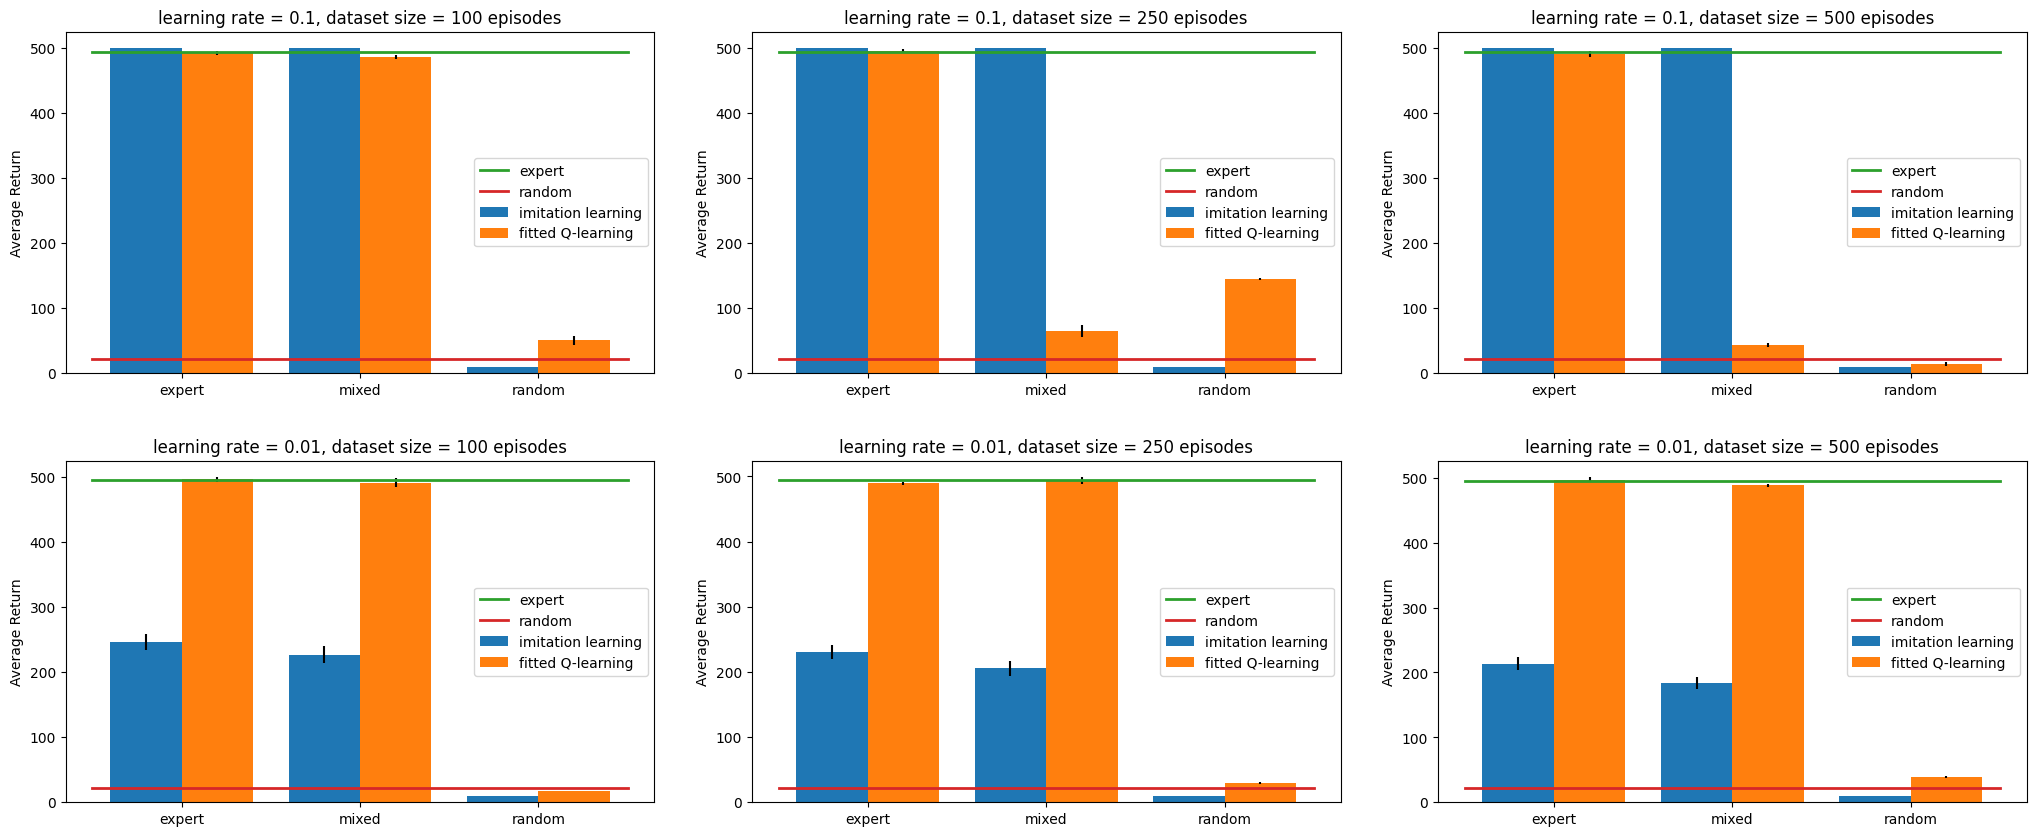

In [ ]:
learning_rates = [0.1, 0.01]
dataset_sizes = [100, 250, 500]

X = ['expert', 'mixed', 'random']
X_axis = np.arange(len(X))

fig, axs = plt.subplots(2,3,figsize=(21,9))

for i in range(2):
  for j in range(3):

    axs[i,j].bar(X_axis - 0.2, imitation_avg_returns[i,j], yerr=imitation_stderr[i,j], width=0.4, label='imitation learning')
    axs[i,j].bar(X_axis + 0.2, fittedQ_avg_returns[i,j], yerr=fittedQ_stderr[i,j], width=0.4, label='fitted Q-learning')
    axs[i,j].plot(np.arange(4)-0.5, np.ones(4)*expert_avg, label='expert', color='C2', linewidth=2)
    axs[i,j].plot(np.arange(4)-0.5, np.ones(4)*random_avg, label='random', color='C3', linewidth=2)

    axs[i,j].set_xticks(X_axis, X)
    axs[i,j].set_ylabel("Average Return")
    axs[i,j].set_title("learning rate = "+str(learning_rates[i])+", dataset size = "+str(dataset_sizes[j])+" episodes")
    axs[i,j].legend()

fig.tight_layout(pad=3)